# Test FANET NN

## Imports

In [1]:
import tensorflow as tf
import pandas as pd # for data manipulation 
import numpy as np
import glob, math, os
from scipy import special
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def euclidean_dist(row):
    # Function to calc euclidean distance on every df row 
    euc_dist = math.sqrt(row["U2G_Distance"]**2 - row["Height"]**2)
    return euc_dist

def q_func(x):
    q = 0.5 - 0.5*special.erf(x / np.sqrt(2))
    return q

def friis_calc(P,freq,dist,ple):
    '''
    Friis path loss equation
    P = Tx transmit power
    freq = Signal frequency
    dist = Transmission distance
    ple = Path loss exponent
    '''
    propagation_speed = 299792458
    l = propagation_speed / freq
    h_pl = P * l**2 / (16*math.pi**2)
    P_Rx = h_pl * dist**(-ple)
    return P_Rx

def plos_calc(h_dist, height_tx, height_rx, env='suburban'):
    '''
    % This function implements the LoS probability model from the paper
    % "Blockage Modeling for Inter-layer UAVs Communications in Urban
    % Environments" 
    % param h_dist    : horizontal distance between Tx and Rx (m)
    % param height_tx : height of Tx
    % param height_rx : height of Rx
    '''
    if env == 'suburban':
        a1 = 0.1
        a2 = 7.5e-4
        a3 = 8
    elif env == 'urban':
        a1 = 0.3
        a2 = 5e-4
        a3 = 15
    
    delta_h = height_tx - height_rx
    # pow_factor = 2 * h_dist * math.sqrt(a1*a2/math.pi) + a1 # NOTE: Use this pow_factor if assuming PPP building dist.
    pow_factor = h_dist * math.sqrt(a1*a2) # NOTE: Use this pow_factor if assuming ITU-R assumptions.
    if delta_h == 0:
        p = (1 - math.exp((-(height_tx)**2) / (2*a3**2))) ** pow_factor
    else:
        if delta_h < 0:
            h1 = height_rx
            h2 = height_tx
        else:
            h1 = height_tx
            h2 = height_rx
        delta_h = abs(delta_h)
        p = (1 - (math.sqrt(2*math.pi)*a3 / delta_h) * abs(q_func(h1/a3) - q_func(h2/a3))) ** pow_factor
    return p

def sinr_lognormal_approx(h_dist, height, env='suburban'):
    '''
    To approximate the SNR from signal considering multipath fading and shadowing
    Assuming no interference due to CSMA, and fixed noise
    Inputs:
    h_dist = Horizontal Distance between Tx and Rx
    height = Height difference between Tx and Rx
    env = The operating environment (currently only suburban supported)
    '''
    # Signal properties
    P_Tx_dBm = 20 # Transmit power of 
    P_Tx = 10**(P_Tx_dBm/10) / 1000
    freq = 2.4e9 # Channel frequency (Hz)
    noise_dBm = -86
    noise = 10**(noise_dBm/10) / 1000
    if env == "suburban":
        # ENV Parameters Constants ----------------------------------
        # n_min = 2
        # n_max = 2.75
        # K_dB_min = 7.8
        # K_dB_max = 17.5
        # K_min = 10**(K_dB_min/10)
        # K_max = 10**(K_dB_max/10)
        # alpha = 11.25 # Env parameters for logarithm std dev of shadowing 
        # beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        n_min = 2
        n_max = 2.75
        K_dB_min = 1.4922
        K_dB_max = 12.2272
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 11.1852 # Env parameters for logarithm std dev of shadowing 
        beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        # -----------------------------------------------------------
    elif env == "urban":
        n_min = 1.9
        n_max = 2.7
        K_dB_min = -5
        K_dB_max = 15
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 10.42 # Env parameters for logarithm std dev of shadowing 
        beta = 0.05 # Env parameters for logarithm std dev of shadowing 
    # Calculate fading parameters
    PLoS = plos_calc(h_dist, 0, height, env=env)
    theta_Rx = math.atan2(height, h_dist) * 180 / math.pi # Elevation angle in degrees
    ple = (n_min - n_max) * PLoS + n_max # Path loss exponent
    sigma_phi_dB = alpha*math.exp(-beta*theta_Rx)
    sigma_phi = 10**(sigma_phi_dB/10) # Logarithmic std dev of shadowing
    K = K_min * math.exp(math.log(K_max/K_min) * PLoS**2)
    omega = 1 # Omega of NCS (Rician)
    dist = math.sqrt(h_dist**2 + height**2)
    P_Rx = friis_calc(P_Tx, freq, dist, ple)
    # Approximate L-NCS RV (which is the SNR) as lognormal
    eta = math.log(10) / 10
    mu_phi = 10*math.log10(P_Rx)
    E_phi = math.exp(eta*mu_phi + eta**2*sigma_phi**2/2) # Mean of shadowing RV
    var_phi = math.exp(2*eta*mu_phi+eta**2*sigma_phi**2)*(math.exp(eta**2*sigma_phi**2)-1) # Variance of shadowing RV
    E_chi = (special.gamma(1+1)/(1+K))*special.hyp1f1(-1,1,-K)*omega
    var_chi = (special.gamma(1+2)/(1+K)**2)*special.hyp1f1(-2,1,-K)*omega**2 - E_chi**2
    E_SNR = E_phi * E_chi / noise # Theoretical mean of SINR
    var_SNR = ((var_phi+E_phi**2)*(var_chi+E_chi**2) - E_phi**2 * E_chi**2) / noise**2
    std_dev_SNR = math.sqrt(var_SNR)
    # sigma_ln = math.sqrt(math.log(var_SNR/E_SNR**2 + 1))
    # mu_ln = math.log(E_SNR) - sigma_ln**2/2
    return E_SNR, std_dev_SNR

def normalize_data(df, columns=[], save_details_path=None):
    '''
    columns: The pandas data columns to normalize, given as a list of column names
    '''
    # Define the ranges of parametrers
    max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
    max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
    min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
    min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
    max_height = 300
    min_height = 60
    max_h_dist = 1200
    min_h_dist = 0
    max_mcs = 7
    min_mcs = 0

    # Normalize data (Min Max Normalization between [-1,1])
    if "Height" in columns:
        df["Height"] = df["Height"].apply(lambda x: 2*(x-min_height)/(max_height-min_height) - 1)
    if "U2G_H_Dist" in columns:
        df["U2G_H_Dist"] = df["U2G_H_Dist"].apply(lambda x: 2*(x-min_h_dist)/(max_h_dist-min_h_dist) - 1)
    if "Mean_SINR" in columns:
        df["Mean_SINR"] = df["Mean_SINR"].apply(lambda x: 2*(10*math.log10(x)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1) # Convert to dB space
    if "Std_Dev_SINR" in columns:
        df["Std_Dev_SINR"] = df["Std_Dev_SINR"].apply(lambda x: 2*(10*math.log10(x)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1) # Convert to dB space
    if "UAV_Sending_Interval" in columns:
        df["UAV_Sending_Interval"] = df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 66.7: 0.5, 100:1, 1000:2})
    if "Packet_State" in columns:
        df['Packet_State'] = df['Packet_State'].replace({"Reliable":0, "QUEUE_OVERFLOW":1, "RETRY_LIMIT_REACHED":2, "Delay_Exceeded":3})
    if "Modulation" in columns:
        df['Modulation'] = df['Modulation'].replace({"BPSK":1, "QPSK":0.3333, 16:-0.3333, "QAM-16":-0.3333, "QAM16":-0.3333, 64:-1, "QAM-64":-1, "QAM64":-1})
    if "MCS" in columns:
        df["MCS"] = df["MCS"].apply(lambda x: 2*(x-min_mcs)/(max_mcs-min_mcs) - 1)

    # Record details of inputs and output for model
    if save_details_path is not None:
        f = open(os.path.join(save_details_path,"model_details.txt"), "w")
        f.write("Max Height (m): {}\n".format(max_height))
        f.write("Min Height (m): {}\n".format(min_height))
        f.write("Max H_Dist (m): {}\n".format(max_h_dist))
        f.write("Min H_Dist (m): {}\n".format(min_h_dist))
        f.write("Max Mean SINR (dB): {}\n".format(max_mean_sinr))
        f.write("Min Mean SINR (dB): {}\n".format(min_mean_sinr))
        f.write("Max Std Dev SINR (dB): {}\n".format(max_std_dev_sinr))
        f.write("Min Std Dev SINR (dB): {}\n".format(min_std_dev_sinr))
        f.write("[BPSK: 1, QPSK: 0.3333, QAM16: -0.3333, QAM64: -1]\n")
        f.write("UAV Sending Interval: [10:-1, 20:-0.5, 40:0, 100:0.5, 1000:1]\n")
        f.write("Output: ['Reliable':0, 'QUEUE_OVERFLOW':1, 'RETRY_LIMIT_REACHED':2, 'Delay_Exceeded':3]\n")
        f.close()

    return df

def get_mcs_index(df_in):
    '''
    Gets the MCS index based on modulation and bitrate column of the df_in
    '''
    df = df_in.copy()
    df["MCS"] = ''
    df.loc[(df["Modulation"] == "BPSK") & (df["Bitrate"] == 6.5), "MCS"] = 0 # MCS Index 0
    df.loc[(df["Modulation"] == "QPSK") & (df["Bitrate"] == 13), "MCS"] = 1 # MCS Index 0
    df.loc[(df["Modulation"] == "QPSK") & (df["Bitrate"] == 19.5), "MCS"] = 2 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM16") & (df["Bitrate"] == 26), "MCS"] = 3 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM16") & (df["Bitrate"] == 39), "MCS"] = 4 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 52), "MCS"] = 5 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 58.5), "MCS"] = 6 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 65), "MCS"] = 7 # MCS Index 0

    return df

2023-12-14 13:03:29.359447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 13:03:29.467474: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 13:03:29.471842: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-14 13:03:29.471856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

## Test using Reliability.csv File

In [20]:
# Set minimum probability for failure mode to be considered
MIN_FAILURE_PROB = 0.01

# model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_DJISpark/nn_checkpoints/djispark_nnv4_wobn_vid/model.010-0.2581.h5", compile=False)
# model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_ParrotAR2/nn_checkpoints/parrotar2_nnv4_wobn_finetune_vid/model.001-0.2580.h5", compile=False)
model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_DJIMavicAir/nn_checkpoints/djimavicair_nnv4_wobn_finetune_vid/model.001-0.2610.h5", compile=False)
model.compile(optimizer='adam', 
              loss={'packet_state': 'categorical_crossentropy'},
              metrics={'packet_state': 'accuracy'})

test_data_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_DJIMavicAir/Test_Dataset_2_NP10000_DJIMavicAir_Video_Reliability.csv")
test_data_df = get_mcs_index(test_data_df)
test_data_df = normalize_data(test_data_df, columns=["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS"], save_details_path=None)

test_data_df["Reliability"] = (test_data_df["Num_Reliable"] / test_data_df["Num_Sent"]).values
test_data_df["Delay_Excd_Prob"] = (test_data_df["Num_Delay_Excd"] / test_data_df["Num_Sent"]).values
test_data_df["Queue_Overflow_Prob"] = (test_data_df["Num_Q_Overflow"] / test_data_df["Num_Sent"]).values
test_data_df["Incr_Rcvd_Prob"] = (test_data_df["Num_Incr_Rcvd"] / test_data_df["Num_Sent"]).values

prediction = model.predict(test_data_df[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS"]].values)

# Save the results to CSV
test_data_df['Predicted_Reliability'] = [prob[0] for prob in prediction]
test_data_df['Predicted_Queue_Overflow_Prob'] = [prob[1] for prob in prediction]
test_data_df['Predicted_Incr_Rcvd_Prob'] = [prob[2] for prob in prediction]
test_data_df['Predicted_Delay_Excd_Prob'] = [prob[3] for prob in prediction]

test_data_df["Reliability_Class"] = pd.cut(test_data_df["Reliability"], bins=[-0.1,0.2,0.5,0.8,1], labels=["Low", "ModeratelyLow", "ModeratelyHigh", "High"])
test_data_df["Predicted_Reliability_Class"] = pd.cut(test_data_df["Predicted_Reliability"], bins=[-0.1,0.2,0.5,0.8,1], labels=["Low", "ModeratelyLow", "ModeratelyHigh", "High"])
test_data_df["Failure_Mode"] = test_data_df[["Queue_Overflow_Prob", "Incr_Rcvd_Prob", "Delay_Excd_Prob"]].idxmax(axis=1)
test_data_df["Predicted_Failure_Mode"] = test_data_df[["Predicted_Queue_Overflow_Prob", "Predicted_Incr_Rcvd_Prob", "Predicted_Delay_Excd_Prob"]].idxmax(axis=1)
# Replace label for Failure Mode with "None" if none of the failure modes have a probability > 5%
test_data_df.loc[(test_data_df["Queue_Overflow_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Incr_Rcvd_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Delay_Excd_Prob"] < MIN_FAILURE_PROB),["Failure_Mode"]] = "None"
test_data_df.loc[(test_data_df["Predicted_Queue_Overflow_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Predicted_Incr_Rcvd_Prob"] < MIN_FAILURE_PROB) & (test_data_df["Predicted_Delay_Excd_Prob"] < MIN_FAILURE_PROB),["Predicted_Failure_Mode"]] = "None"

# Compute the model accuracy and mean abs err
failure_mode = test_data_df["Failure_Mode"].replace({"Queue_Overflow_Prob":1, "Incr_Rcvd_Prob":2, "Delay_Excd_Prob":3, "None":4})
failure_mode_predicted = test_data_df["Predicted_Failure_Mode"].replace({"Predicted_Queue_Overflow_Prob":1, "Predicted_Incr_Rcvd_Prob":2, "Predicted_Delay_Excd_Prob":3, "None":4})
reliability_accuracy = accuracy_score(test_data_df["Reliability_Class"], test_data_df["Predicted_Reliability_Class"])
failure_mode_accuracy = accuracy_score(failure_mode, failure_mode_predicted)
reliability_mae = np.mean(abs(test_data_df['Reliability'].values - test_data_df['Predicted_Reliability'].values))
queue_overflow_mae = np.mean(abs(test_data_df['Queue_Overflow_Prob'].values - test_data_df['Predicted_Queue_Overflow_Prob'].values))
incr_rcvd_mae = np.mean(abs(test_data_df['Incr_Rcvd_Prob'].values - test_data_df['Predicted_Incr_Rcvd_Prob'].values))
delay_excd_mae = np.mean(abs(test_data_df['Delay_Excd_Prob'].values - test_data_df['Predicted_Delay_Excd_Prob'].values))
reliability_maxae = np.max(abs(test_data_df['Reliability'].values - test_data_df['Predicted_Reliability'].values))
queue_overflow_maxae = np.max(abs(test_data_df['Queue_Overflow_Prob'].values - test_data_df['Predicted_Queue_Overflow_Prob'].values))
incr_rcvd_maxae = np.max(abs(test_data_df['Incr_Rcvd_Prob'].values - test_data_df['Predicted_Incr_Rcvd_Prob'].values))
delay_excd_maxae = np.max(abs(test_data_df['Delay_Excd_Prob'].values - test_data_df['Predicted_Delay_Excd_Prob'].values))

# Print results
print("Reliability - Accuracy: {}, MAE: {}, MaxAE: {}".format(reliability_accuracy, reliability_mae, reliability_maxae))
print("Failure Mode - Accuracy: {}".format(failure_mode_accuracy))
print("Queue Overflow - MeanAE: {}, MaxAE: {}".format(queue_overflow_mae, queue_overflow_maxae))
print("Incorrectly Received - MeanAE: {}, MaxAE: {}".format(incr_rcvd_mae, incr_rcvd_maxae))
print("Delay Exceeded - MeanAE: {}, MaxAE: {}".format(delay_excd_mae, delay_excd_maxae))
print("Average Failure Mode Mean AE: {}".format(np.mean([queue_overflow_mae, incr_rcvd_mae, delay_excd_mae])))
# Save results to file
test_data_df.to_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_DJIMavicAir/Test_Dataset_2_NP10000_DJIMavicAir_Video_Reliability_RESULTS_finetune_nnv4.csv")

60/60 [==============================] - 0s 986us/step


Reliability - Accuracy: 0.984375, MAE: 0.003680582947075181, MaxAE: 0.32447749686241145
Failure Mode - Accuracy: 0.9921875
Queue Overflow - MeanAE: 0.007562793216401282, MaxAE: 0.2879577778816223
Incorrectly Received - MeanAE: 0.003986971634038475, MaxAE: 0.024353244510293005
Delay Exceeded - MeanAE: 0.0030872868768628157, MaxAE: 0.17464021558761597
Average Failure Mode Mean AE: 0.004879017242434191


## Plot Results

0.0038569096690441685


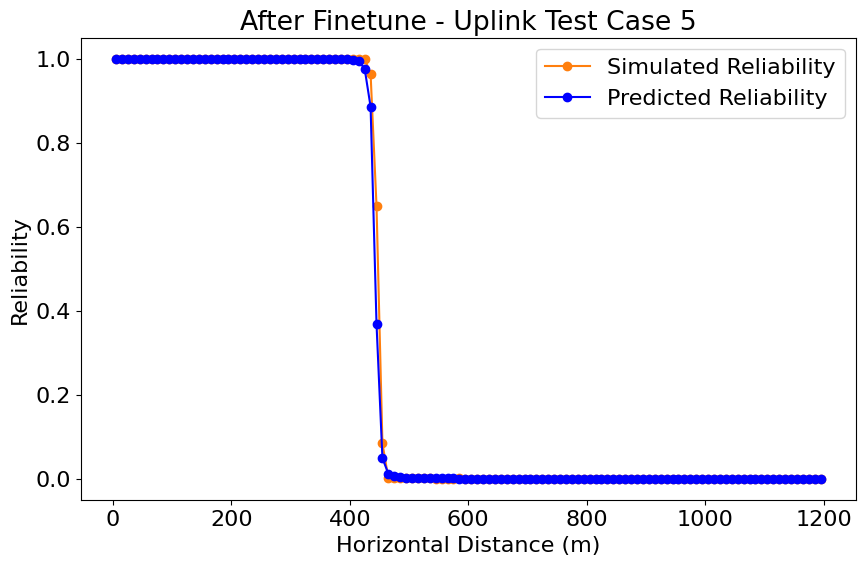

In [12]:
results_df = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_DJIMavicAir/Test_Dataset_NP10000_DJIMavicAir_Downlink_Reliability_RESULTS_finetune_nnv4.csv")
modulation = 0.3333
uav_send_int = 1
results = results_df.loc[(results_df["Modulation"]==modulation) & (results_df["UAV_Sending_Interval"]==uav_send_int)]

plt.figure(figsize=(10,6))
plt.plot(results['Horizontal_Distance'], results['Reliability'], '-o', color='tab:orange', label='Simulated Reliability')
plt.plot(results['Horizontal_Distance'], results['Predicted_Reliability'], '-o', color='blue', label='Predicted Reliability')
plt.ylabel("Reliability")
plt.xlabel("Horizontal Distance (m)")
plt.title("After Finetune - Uplink Test Case 5")
plt.legend()
plt.rcParams.update({'font.size': 16})

reliability_mae = np.mean(abs(results['Reliability'].values - results['Predicted_Reliability'].values))
print(reliability_mae)

## Misc

In [ ]:
mean_s, std_dev_s = sinr_lognormal_approx(20, 60)
max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
norm_m_s = 2*(10*math.log10(mean_s)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
norm_std_s = 2*(10*math.log10(std_dev_s)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
print(norm_m_s, norm_std_s)

In [ ]:
# model = tf.keras.models.load_model("/home/research-student/omnetpp_sim_results/PCAP_Test/ParrotAR2_ConstantSI/new_train_v5_model.001-2.2366.h5", compile=False)
model = tf.keras.models.load_model("/home/research-student/omnetpp_sim_results/PCAP_Test/ParrotAR2_ConstantSI/model.001-537.3792.h5", compile=False)
# model = tf.keras.models.load_model("/home/research-student/omnetpp_sim_results/PCAP_Test/ParrotAR2_ConstantSI/old_train_model.001-0.2859.h5", compile=False)
model.compile(optimizer='adam', 
              loss={'packet_state': 'categorical_crossentropy'},
              metrics={'packet_state': 'accuracy'})

prediction = model.predict([[0.216849154694174,-0.005619989525325,0,1], [-0.001159232266319,-0.260680656304825,-0.5,1]])
print(prediction)

In [ ]:
model = tf.keras.models.load_model("/home/research-student/omnetpp_sim_results/PCAP_Test/ParrotAR2_ConstantSI/model.004-1.3445.h5", compile=False)
# model = tf.keras.models.load_model("/home/research-student/omnetpp_sim_results/PCAP_Test/ParrotAR2_ConstantSI/model.010-39710.3672.h5", compile=False)
# model = tf.keras.models.load_model("/home/research-student/omnetpp_sim_results/PCAP_Test/DJISpark_ConstantSI/dl_nn_ckpt/model.001-0.6887.h5", compile=False)
model.compile(optimizer='adam', 
              loss={'packet_state': 'categorical_crossentropy'},
              metrics={'packet_state': 'accuracy'})

# prediction = model.predict([[0.9999471101206907,0.9994819605785321,0.5,-0.3333], [0.9533792612883014,0.954807009561927,-0.5,-1]])
prediction = model.predict([[0.9999471101206907,0.9994819605785321,0.5,-0.3333], [0.9533792612883014,0.954807009561927,0.5,-0.3333]])
print(prediction)